<a href="https://colab.research.google.com/github/btgamble/Foundational-methodology/blob/master/penv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [ ]:
!pip install tensortrade==1.0.0b0

### Imports

In [ ]:
from collections import deque
from typing import List

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import tensortrade.env.generic as generic
from gym.spaces import Space, Dict, Box
from scipy.special import binom
from scipy.stats import truncnorm
from tensortrade.env.default import TradingEnv
from tensortrade.feed import Stream, DataFeed, NameSpace

plt.style.use("seaborn")

### Metrics

In [ ]:
def sharpe(returns: np.array, risk_free_rate: float = 0) -> float:
    return (returns.mean() - risk_free_rate) / returns.std()


def maximum_drawdown(net_worth: np.array) -> float:
    n = len(net_worth)
    nav = net_worth.copy()
    mdd = 0
    peak = -np.inf
    for i in range(n):
        if nav[i] > peak:
            peak = nav[i]
        dd = 100*(peak - nav[i]) / peak

        if dd > mdd:
            mdd = dd
    return mdd

### Environment

In [ ]:
class Simplex(Space):

    def __init__(self, m: int):
        assert m >= 1
        super().__init__(shape=(m + 1, ), dtype=np.float32)
        self.m = m

    def sample(self) -> np.array:
        return np.random.dirichlet(alpha=(1 + self.m)*[1 + 3*np.random.random()])

    def contains(self, x) -> bool:
        if len(x) != self.m + 1:
            return False
        if not np.testing.assert_almost_equal(sum(x), 1.0):
            return False
        return True


class Observer(generic.Observer):

    def __init__(self,
                 feed: DataFeed = None,
                 window_size: int = 1,
                 **kwargs) -> None:
        super().__init__()
        self.feed = feed
        self.feed.compile()

        self.window_size = window_size
        self.keys = None

        self.history = deque([], maxlen=self.window_size)
        self.state = None
        self.renderer_history = []
        self.min_periods = kwargs.get("min_periods", window_size)

        assert self.min_periods >= self.window_size

    @property
    def observation_space(self) -> Space:
        obs = self.feed.next()["obs"]
        self.keys = [k for k in obs]
        space = Box(-np.inf, np.inf, shape=(self.window_size, len(self.keys)), dtype=np.float64)
        self.feed.reset()
        return space

    def warmup(self) -> None:
        for _ in range(self.min_periods):
            if self.feed.has_next():
                obs = self.feed.next()["obs"]
                self.history += [[obs[k] for k in self.keys]]

    def observe(self, env) -> np.array:
        data = self.feed.next()

        self.state = data["state"]

        if "performance" in data.keys():
            self.renderer_history += [data["performance"]]

        obs = data["obs"]
        self.history += [[obs[k] for k in self.keys]]

        return np.array(self.history)

    def reset(self) -> None:
        self.renderer_history = []
        self.history = deque([], maxlen=self.window_size)
        self.feed.reset()
        self.warmup()


class PortfolioAllocation(generic.ActionScheme):

    def __init__(self, num_assets: int, commission: float):
        super().__init__()
        self.num_assets = num_assets
        self.commission = commission

        self.p = 1.0
        self.mu = None
        self.weights = np.array([1] + self.num_assets*[0])
        self.buffer = deque([self.p], maxlen=2)

    @property
    def action_space(self):
        return Simplex(m=self.num_assets)

    def update_mu(self, w, w_p, y) -> float:
        c = self.commission

        if self.mu is None:
            self.mu = c * abs(w_p[1:] - w[1:]).sum()

        ts = (w_p[1:] - self.mu * w[1:]).clip(min=0).sum()
        num = (1 - c*w_p[0]) - c*(2 - c)*ts
        den = 1 - c*w[0]

        self.mu = num / den

    def perform(self, env, action):
        np.testing.assert_almost_equal(action.sum(), 1.0, decimal=5)

        state = env.observer.state

        y1 = state["y(t+1)"]
        y1 = np.array([1] + list(y1))

        w = (y1 * self.weights) / np.dot(y1, self.weights)
        w_p = action.copy()

        self.update_mu(w, w_p, y1)

        self.p *= self.mu*np.dot(y1, w_p)

        self.weights = w_p
        self.buffer += [self.p]

    def reset(self):
        self.p = 1.0
        self.weights = np.array([1] + self.num_assets*[0])
        self.buffer = deque([self.p], maxlen=2)


class Profit(generic.RewardScheme):

    def reward(self, env):
        buffer = env.action_scheme.buffer
        return buffer[1] - buffer[0]


class MaxStepsOrNoMoney(generic.Stopper):

    def stop(self, env) -> bool:
        p = env.action_scheme.p
        return (p == 0) or not env.observer.feed.has_next()


class RebalanceInformer(generic.Informer):

    def info(self, env) -> dict:
        return {
            "step": self.clock.step,
        }


class ReallocationChart(generic.Renderer):

    def __init__(self, num_assets: int):
        super().__init__()
        self.num_assets = num_assets

    def render(self, env, **kwargs):
        history = env.observer.renderer_history
        df = pd.DataFrame(history)

        sr = round(sharpe(df.pv.pct_change()), 2)
        mdd = round(maximum_drawdown(df.pv), 2)

        fig, axs = plt.subplots(self.num_assets + 2, 1, figsize=(2*(self.num_assets + 2) + 5, 10), sharex=True)

        fig.suptitle(f"Portfolio Reallocation Chart (Sharpe: {sr}, MDD: {mdd}%)")

        x = list(range(len(history)))

        axs[0].set_ylabel(f"Cash")
        axs[0].set_xlim(0, len(history))

        ax2 = axs[0].twinx()
        ax2.plot(x, [row["weights"][0] for row in history], color="r")
        ax2.set_ylabel("Weight")
        ax2.set_ylim(0, 1)

        for i in range(self.num_assets):

            y1 = [row["prices"][i] for row in history]
            y2 = [row["weights"][i + 1] for row in history]

            ax = axs[i + 1]
            ax.plot(x, y1)
            ax.set_ylabel(f"Asset {i + 1}")
            ax.set_xlim(0, len(history))

            ax2 = ax.twinx()
            ax2.plot(x, y2, color="r")
            ax2.set_ylabel("Weight")
            ax2.set_ylim(0, 1)

        df.pv.plot(ax=axs[-1])
        axs[-1].set_xlabel("Step")
        axs[-1].set_ylabel("Portfolio Value")

        plt.tight_layout()
        plt.show()

### Features

In [ ]:
class MultiSinePriceCurves(Stream[np.array]):

    def __init__(self, s0: np.array, shift: np.array, freq: np.array, n: int, warmup: int = 0):
        super().__init__()
        self.s0 = s0
        self.shift = shift
        self.freq = freq

        self.steps = n + warmup + 1
        self.i = 0
        self.m = len(s0)

        self.x = np.linspace(-2*np.pi*(warmup / n), 2*np.pi, num=self.steps)

    def forward(self) -> np.array:
        rv = truncnorm.rvs(a=-10, b=10, size=self.m)
        v = self.s0 + 25*np.sin(self.freq*(self.x[self.i] - self.shift)) + rv
        self.i += 1
        return v

    def has_next(self):
        return self.i < self.steps

    def reset(self):
        super().reset()
        self.i = 0


def fracdiff(s: Stream[float], d: float, window: int) -> Stream[float]:
    c = np.tile([1.0, -1.0], -(-window // 2))[:window]
    w = c*binom(d, np.arange(window))
    w = w[::-1]
    frac = s.rolling(window=window, min_periods=window).agg(lambda v: np.dot(w.T, v))
    return frac


def macd(s: Stream[float], fast: int, slow: int, signal: int) -> Stream[float]:
    fm = s.ewm(span=fast, adjust=False).mean()
    sm = s.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal


def rsi(s: Stream[float], period: float, use_multiplier: bool = True) -> Stream[float]:
    r = s.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    v = 1 - (1 + rs)**-1
    return 100*v if use_multiplier else v


def make_features(s: Stream[float]) -> List[Stream[float]]:
    return [
        fracdiff(s, d=0.6, window=25).lag().rename("fd"),
        macd(s, fast=20, slow=100, signal=50).lag().rename("macd"),
        rsi(s, period=20, use_multiplier=False).lag().rename("rsi")
    ]

### Environment Creation

In [ ]:
def index(i: int):
    def f(x: np.array):
        return x[i]
    return f


def create_env(config: dict):

    np.seterr(divide="ignore")

    action_scheme = PortfolioAllocation(
        num_assets=config["num_assets"],
        commission=config["commission"]
    )

    total_steps = config["total_steps"] + config["min_periods"]
    m = config["num_assets"]

    s = MultiSinePriceCurves(
        s0=np.array([50, 48, 45, 60]),
        shift=np.array([0, np.pi / 2, np.pi, 3*np.pi / 2]),
        freq=np.array([1, 5, 3, 2]),
        n=config["total_steps"],
        warmup=config["min_periods"]
    )
    p_streams = [s.apply(index(i), dtype="float").rename(f"p{i}") for i in range(m)]
    lag_streams = [p_streams[i].lag().rename(f"l{i}") for i in range(m)]

    prices = Stream.group(lag_streams).apply(lambda x: np.array([x[f"l{i}"] for i in range(m)])).rename("prices")

    features = []
    for i in range(m):
        with NameSpace(f"p{i}"):
            features += make_features(p_streams[i])

    r_streams = [(p_streams[i] / lag_streams[i]).rename(f"r{i}") for i in range(m)]
    y1 = Stream.group(r_streams).apply(lambda x: np.array([x[f"r{i}"]for i in range(m)])).rename("y(t+1)")

    weights = Stream.sensor(action_scheme, lambda x: x.weights).rename("weights")
    pv = Stream.sensor(action_scheme, lambda x: x.p, dtype="float").rename("pv")

    obs_group = Stream.group(features).rename("obs")
    state_group = Stream.group([y1]).rename("state")
    perform_group = Stream.group([prices, weights, pv]).rename("performance")

    feed = DataFeed([obs_group, state_group, perform_group])

    env = TradingEnv(
        action_scheme=action_scheme,
        reward_scheme=Profit(),
        observer=Observer(
            feed=feed,
            window_size=config["window_size"],
            num_assets=config["num_assets"],
            min_periods=config["min_periods"]
        ),
        stopper=MaxStepsOrNoMoney(),
        informer=RebalanceInformer(),
        renderer=ReallocationChart(num_assets=config["num_assets"])
    )

    return env

### Test Run

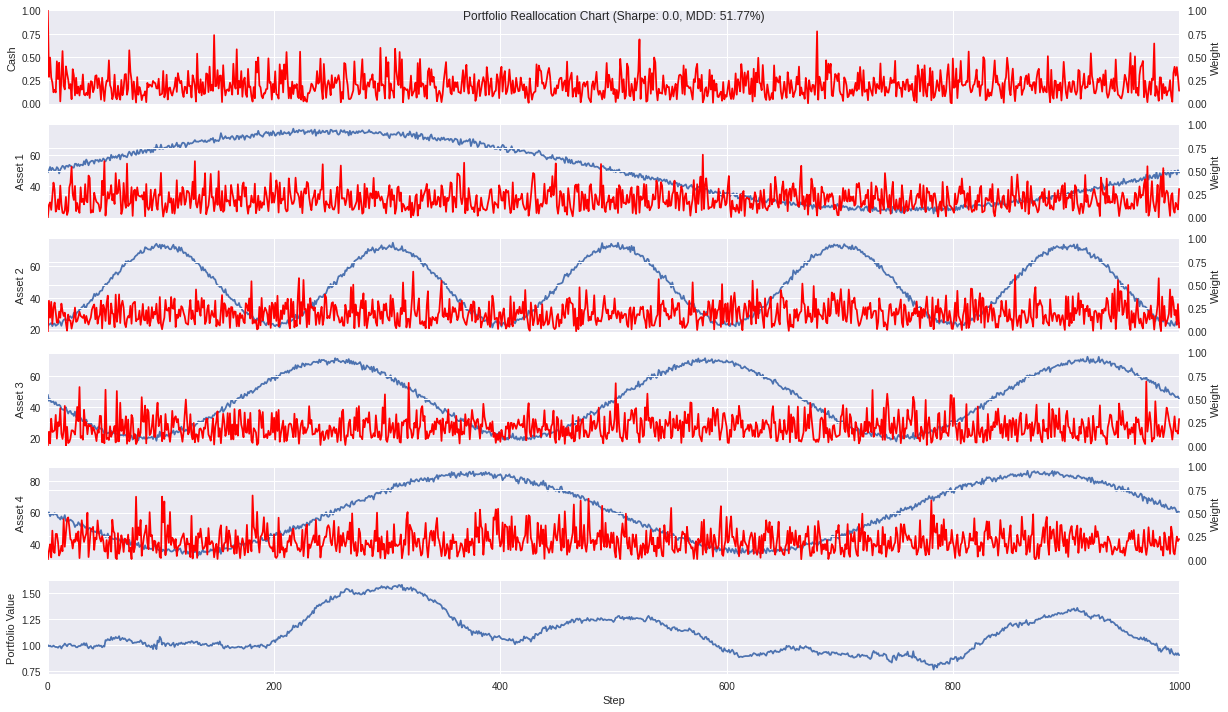

In [ ]:
env = create_env({
    "total_steps": 1000,
    "num_assets": 4,
    "commission": 1e-3,
    "time_cost": 0,
    "window_size": 10,
    "min_periods": 150
})

done = False
obs = env.reset()
action = env.action_scheme.weights.copy()

while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

env.render()